## To do:
* monthly mean vs daily
* detrend data compare
* remove offset from climate projections
* check resolution


In [1]:
# Import libraries
from matplotlib import pyplot as plt
import numpy as np
import netCDF4 as nc
import pandas as pd
import xarray as xr
import run
import func
from scipy.signal import detrend

## Get data

In [2]:
# Read in forcing data
years = np.arange(2000, 2024, 1)
P_data = []
R_data = []
T_data = []
lai_data = []
calibration_time = [2000, 2010]

for year in years:
    file_path = 'data/total_precipitation/tp.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    P_data.append(xr.open_dataset(file_path)['tp'])

    file_path = 'data/net_radiation/nr.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    R_data.append(xr.open_dataset(file_path)['nr'])

    file_path = 'data/daily_average_temperature/t2m_mean.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    T_data.append(xr.open_dataset(file_path)['t2m'])

    file_path = 'data/lai/lai.daily.0d50_CentralEurope.' + str(year) + '.nc'
    lai_data.append(xr.open_dataset(file_path)['lai'])

# Convert lists to xarray datasets
P_data = xr.concat(P_data, dim='time')
R_data = xr.concat(R_data, dim='time')
T_data = xr.concat(T_data, dim='time')
lai_data = xr.concat(lai_data, dim='time')


In [3]:
# Replace the timestamp from LAI
new_time_range = pd.date_range(start='2000-01-01', end='2023-12-31', freq='D')
lai_data['time'] = new_time_range

In [4]:
# Replace first 48 days with them from 2001
torep = lai_data.sel(time = slice("2001-01-01","2001-02-17"))
lai_data.values[0:48, :, :] = torep.values


In [5]:
np.shape(lai_data)

(8766, 22, 22)

In [7]:
gridcells =[]
for lat in range(len(P_data.lat)):
        for lon in range(len(P_data.lon)):
                if np.isnan(lai_data[:, lat, lon]).all():
                    gridcells.append((lat,lon))
len(gridcells)

37

In [8]:
for lat in range(len(P_data.lat)):
    for lon in range(len(P_data.lon)):
        if np.isnan(lai_data[:, lat, lon]).all():
            continue
        else:
            # Get the data for the current grid cell
            grid_cell_data = lai_data[:, lat, lon]
            
            # Convert to DataFrame for easier handling
            grid_cell_df = pd.DataFrame(grid_cell_data)
            
            # Fill NA values with the previous value
            grid_cell_df.fillna(method='ffill', inplace=True)
            
            # Update the grid cell data
            lai_data[:, lat, lon] = grid_cell_df.values.flatten()

C:\Users\motze\AppData\Local\Temp\ipykernel_10260\3542156106.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  grid_cell_df.fillna(method='ffill', inplace=True)
C:\Users\motze\AppData\Local\Temp\ipykernel_10260\3542156106.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  grid_cell_df.fillna(method='ffill', inplace=True)
C:\Users\motze\AppData\Local\Temp\ipykernel_10260\3542156106.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  grid_cell_df.fillna(method='ffill', inplace=True)
C:\Users\motze\AppData\Local\Temp\ipykernel_10260\3542156106.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  grid_cell_df.fillna(method

## Run model for daily values

In [9]:
params = [420, 8, 0.2, 0.8, 1.5, (0.75, 0.25)]

In [34]:
output_daily = func.grid_model(P_data, R_data, T_data, lai_data, params, cell = False)

ImportError: cannot import name '_new_to_legacy_freq' from 'xarray.coding.cftime_offsets' (c:\Users\motze\programs\Miniconda3\envs\esm\Lib\site-packages\xarray\coding\cftime_offsets.py)

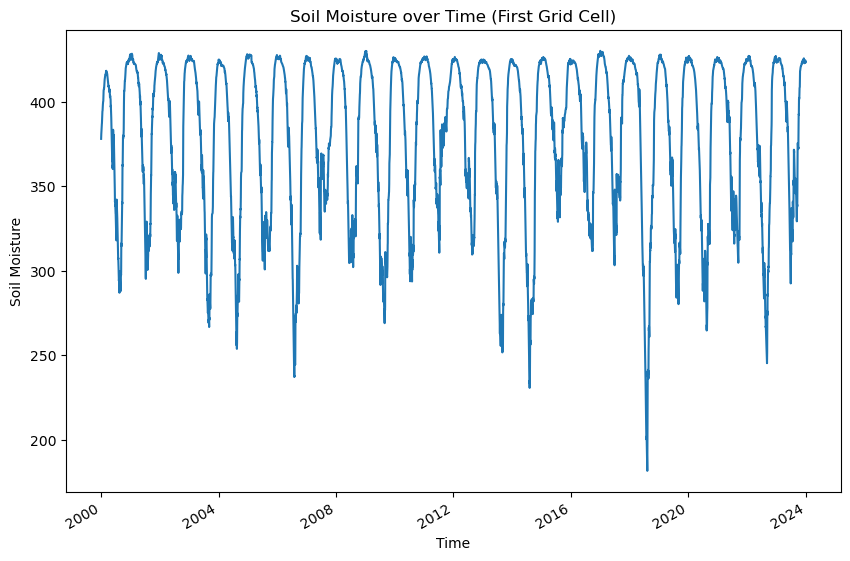

In [9]:
plt.figure(figsize=(10, 6))
output_daily['soil_moisture'].isel(lat=0, lon=0).plot(x='time')
plt.xlabel('Time')
plt.ylabel('Soil Moisture')
plt.title('Soil Moisture over Time (First Grid Cell)')
plt.show()

## Run model on monthly data

In [21]:
# Calculate monthly means
P_monthly = P_data.resample(time='1M').mean(dim='time')
R_monthly = R_data.resample(time='1M').mean(dim='time')
T_monthly = T_data.resample(time='1M').mean(dim='time')
lai_monthly = lai_data.resample(time='1M').mean(dim='time')

In [59]:
output_monthly = func.grid_model(P_monthly, R_monthly, T_monthly, lai_monthly, params, cell = True)

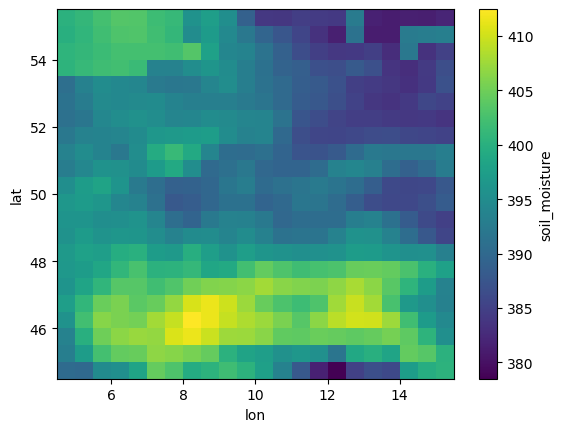

In [61]:
output_monthly['soil_moisture'].max(dim='time').plot()

In [66]:
# Save as csv
#output_monthly_df = output_monthly.to_dataframe()
#output_monthly_df.to_csv("results/monthly_lai_0.csv")

## Run model only for certain gridcells

In [11]:
params = [420, 8, 0.2, 0.8, 1.5, (0.75, 0.25)]

In [12]:
# gridcells to look at
grid = [(4,4),(4,18),(18,4),(18,18)]

In [13]:
# run model
output = func.grid_model_cell(P_data, R_data, T_data, lai_data, params, cells = grid)

(4, 4) done
(4, 18) done
(18, 4) done
(18, 18) done


C:\Users\motze\AppData\Local\Temp\ipykernel_10260\3780478470.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


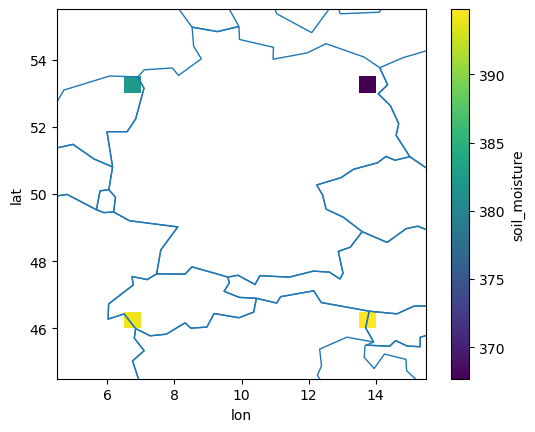

In [19]:
import geopandas as gpd

# Load country boundaries shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot the mean soil moisture
output['soil_moisture'].mean(dim='time').plot()

# Plot country boundaries
world.boundary.plot(ax=plt.gca(), linewidth=1)

plt.show()

## Detrend data

In [20]:
T_data_detrend = func.rem_trend(T_data)

In [21]:
R_data_detrend = func.rem_trend(R_data)

### Run model with detrended data

In [22]:
# Run model with detrended data
output_detrend = func.grid_model_cell(P_data, R_data_detrend, 
                                      T_data_detrend, lai_data, 
                                      params, cells = grid)

(4, 4) done
(4, 18) done
(18, 4) done
(18, 18) done


## Compare

In [23]:
# Calculate the difference to get the trend
difference_data = output - output_detrend

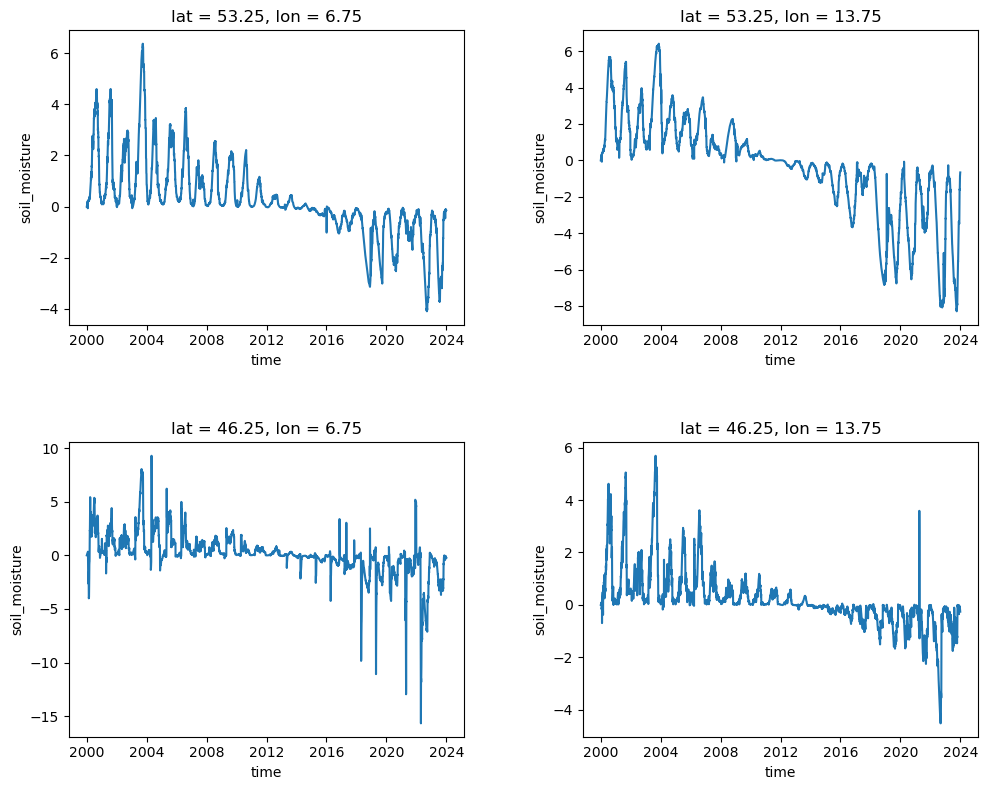

In [24]:
func.plot_func(difference_data, grid,'soil_moisture')

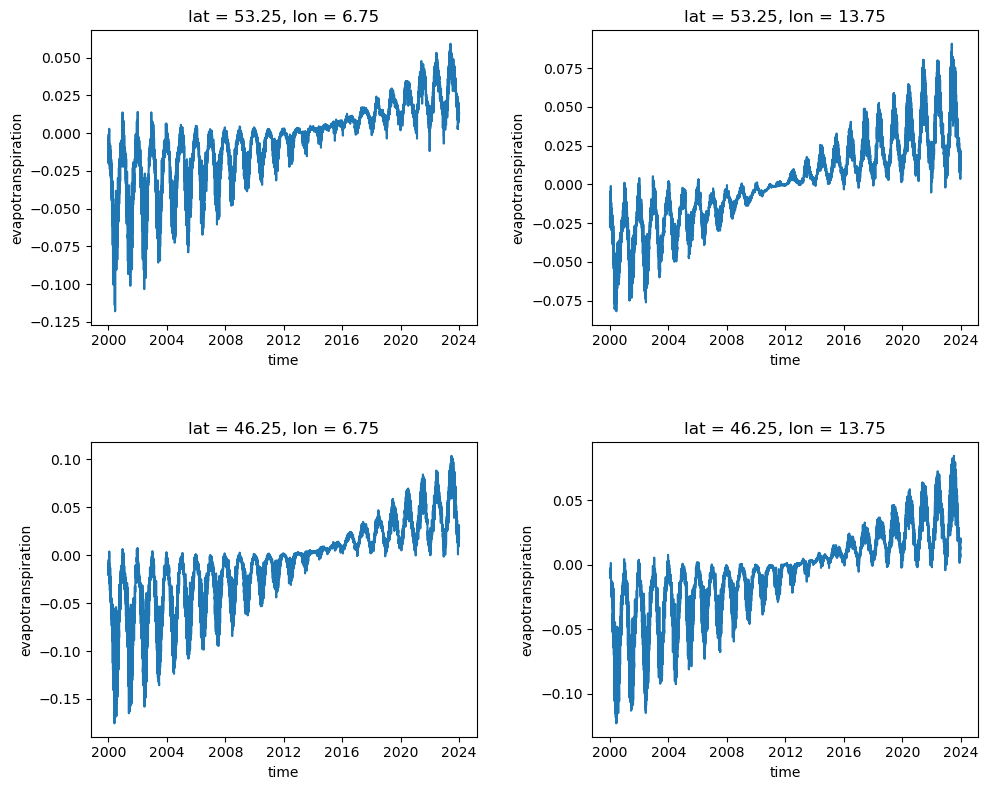

In [25]:
func.plot_func(difference_data, grid,'evapotranspiration')

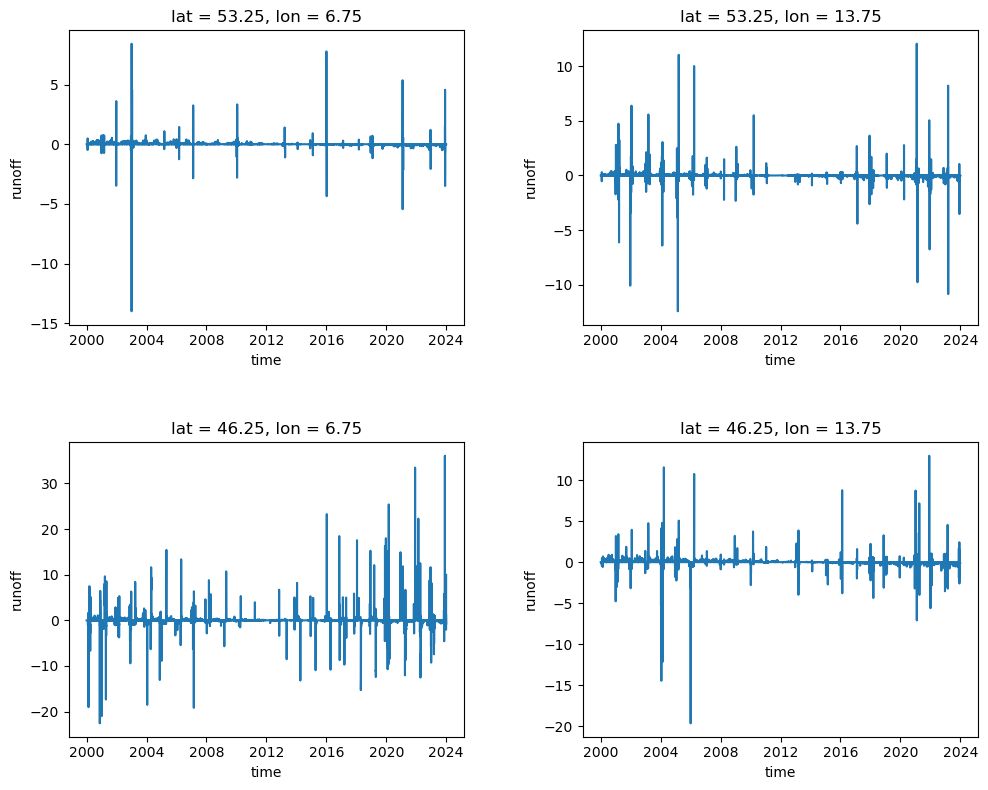

In [26]:
func.plot_func(difference_data, grid,'runoff')

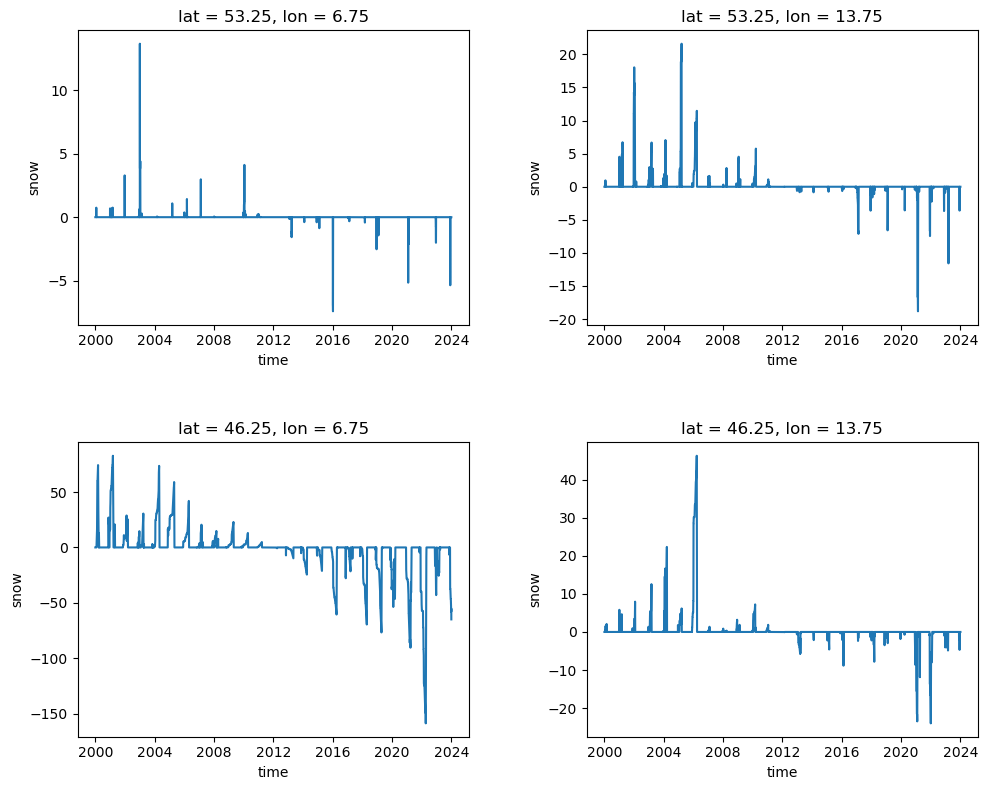

In [27]:
func.plot_func(difference_data, grid,'snow')

## Climate Projections

In [29]:
# Load projection data
lai_sel  = xr.open_dataarray("C:\Users\motze\Desktop\projections_daily\LeafAreaIndex_2000_2100_cropped_offset_daily.nc")
T_sel  = xr.open_dataarray("C:\Users\motze\Desktop\projections_daily\Precipitation_2000_2100_cropped_offset_daily.nc")
R_sel  = xr.open_dataarray("C:\Users\motze\Desktop\projections_daily\RadiationRLS_2000_2100_cropped_offset_daily.nc")
P_sel  = xr.open_dataarray("C:\Users\motze\Desktop\projections_daily\Temperature_2000_2100_cropped_offset_daily.nc")

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (3859273031.py, line 2)

In [57]:
# Select only 2080 to 2100
lai_future = lai_sel.sel(time = slice("2080","2100"))
T_future = T_sel.sel(time = slice("2080","2100"))
R_future = R_sel.sel(time = slice("2080","2100"))
P_future = P_sel.sel(time = slice("2080","2100"))

In [46]:
new_time_range = pd.date_range(start='2080-01-01', end='2100-12-31', freq='D')
len(new_time_range)

252

In [58]:
lai_future['time'] = new_time_range
T_future['time'] = new_time_range
R_future['time'] = new_time_range
P_future['time'] = new_time_range

In [49]:
# Adjust grid because of no data in (4,4)
grid = [(9,4),(4,18),(18,4),(18,18)]

In [50]:
# Run model for future climate
output_future = func.grid_model_cell(P_future, R_future, 
                                      T_future, lai_future, 
                                      params, cells = grid)

(9, 4) done
(4, 18) done
(18, 4) done
(18, 18) done


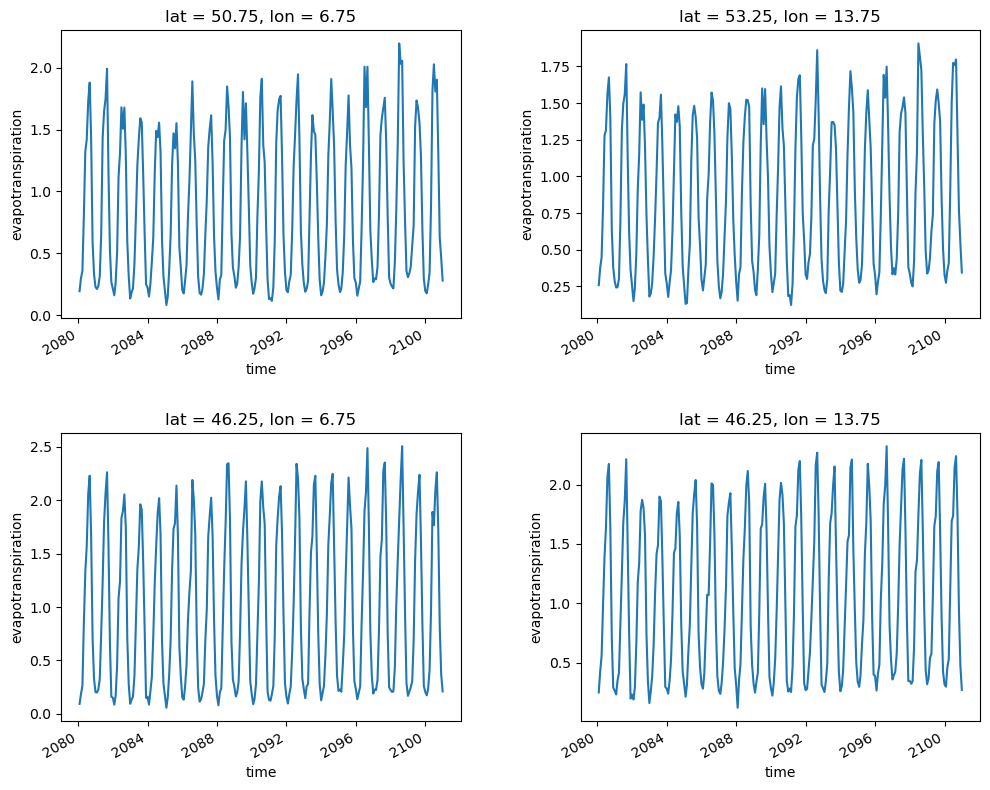

In [55]:
func.plot_func(output_future, grid,'evapotranspiration')

## Detrend climateprojections

In [59]:
T_future_detrend = func.rem_trend(T_future)
R_future_detrend = func.rem_trend(R_future)

In [60]:
# Run model with detrended data
output_future_detrend = func.grid_model_cell(P_future, R_future_detrend, 
                                      T_future_detrend, lai_future, 
                                      params, cells = grid)

(9, 4) done
(4, 18) done
(18, 4) done
(18, 18) done
